In [35]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Function to calculate tree parameters (u, d, p) for different models
def calculate_tree_parameters(r, q, sigma, dt, model_type, drift=0, AmeEur='a'):
    if model_type == 'CRR':
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp(r * dt) - d) / (u - d)
    elif model_type == 'CRR_Drift':
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp((r + drift) * dt) - d) / (u - d)
    elif model_type == 'Jarrow-Rudd':
        u = np.exp(((b) - sigma**2 / 2) * dt + sigma * np.sqrt(dt))
        d = np.exp(((b) - sigma**2 / 2) * dt - sigma * np.sqrt(dt))
        p = (np.exp((b) * dt) - d) / (u - d)
    elif model_type == 'Tian':
        eta=np.exp(dt*sigma**2)
        u=0.5*np.exp(r*dt)*eta*(eta+1+np.sqrt(eta**2+2*eta-3))
        d=0.5*np.exp(r*dt)*eta*(eta+1-np.sqrt(eta**2+2*eta-3))
        p=(np.exp((b)*dt)-d)/(u-d)
    elif model_type == 'EQP':
        p=0.5
        u=np.exp(((b)-sigma**2/2)*dt+sigma*np.sqrt(dt))
        d=np.exp(((b)-sigma**2/2)*dt-sigma*np.sqrt(dt))
    elif model_type == 'Haahtela':
        u = np.exp(r * dt) * (1 + np.sqrt(np.exp((sigma ** 2) * dt) - 1))
        d = np.exp(r * dt) * (1 - np.sqrt(np.exp((sigma ** 2) * dt) - 1))
        p = (np.exp((r - q) * dt) - d) / (u - d)
    else:
        raise ValueError("Unknown model type provided.")

    return u, d, p

def LatticeConvertibleBond(S, T2, t1, r, q, k, sigma, F, X, Coupon, N, model_type = 'CRR', AmeEur='a'):
    # Calculate derived parameters
    b = r - q
    CRatio = F / X
    dt = T2 / N
    u, d, p = calculate_tree_parameters(r, q, sigma, dt, model_type, drift=0, AmeEur='a')
    # Initialize arrays for option values and conversion probabilities
    OptionValue = np.zeros(N + 1)
    ConversionProbability = np.zeros(N + 1)

    # Calculate option value and conversion probability at final time step
    for i in range(N + 1):
        StockPrice = S * (u ** i) * (d ** (N - i))
        OptionValue[i] = max(F + Coupon, CRatio * StockPrice)
        ConversionProbability[i] = 0 if OptionValue[i] == F + Coupon else 1

    CouponTime = T2

    # Backward induction for earlier time steps
    for j in range(N, 0, -1):
        # Determine if it's time to consider coupon payment
        if CouponTime != (T2 - np.ceil((N - j + 1) * dt)):
            CouponPayment = 1
            CouponTime = T2 - np.ceil((N - j) * dt)
            Time = CouponTime - dt * j
        else:
            CouponPayment = 0

        for i in range(j):
            # Calculate effective discount rates
            ru = ConversionProbability[i + 1] * r + (1 - ConversionProbability[i + 1]) * (r + k)
            rd = ConversionProbability[i] * r + (1 - ConversionProbability[i]) * (r + k)
            StockPrice = S * (u ** i) * (d ** (j - i))

            # Calculate the coupon value if applicable
            if CouponPayment == 1:
                CouponValue = Coupon * (p * np.exp(-ru * Time) + (1 - p) * np.exp(-rd * Time))
            else:
                CouponValue = 0

            # Check for European or American exercise conditions
            if AmeEur == 'e' or (AmeEur == 'a' and dt * j <= t1):
                OptionValue[i] = CouponValue + p * OptionValue[i + 1] * np.exp(-ru * dt) + (1 - p) * OptionValue[i] * np.exp(-rd * dt)
                ConversionProbability[i] = p * ConversionProbability[i + 1] + (1 - p) * ConversionProbability[i]
            elif AmeEur == 'a':
                # American option: max of immediate exercise or continuation value
                OptionValue[i] = max(CRatio * (StockPrice - X) + F, CouponValue + p * OptionValue[i + 1] * np.exp(-ru * dt) + (1 - p) * OptionValue[i] * np.exp(-rd * dt))
                if OptionValue[i] == CRatio * (StockPrice - X) + F:
                    ConversionProbability[i] = 1
                else:
                    ConversionProbability[i] = p * ConversionProbability[i + 1] + (1 - p) * ConversionProbability[i]

    return OptionValue[0]

# Example call to the function
result = LatticeConvertibleBond(S=75, T2=5, t1=0, r=0.07, q=0, k=0.03, sigma=0.2, F=100, X=100, Coupon=6, N=5, model_type='CRR' , AmeEur='a')
print("Option Value at t=0: ", result)


Option Value at t=0:  106.23456548322234


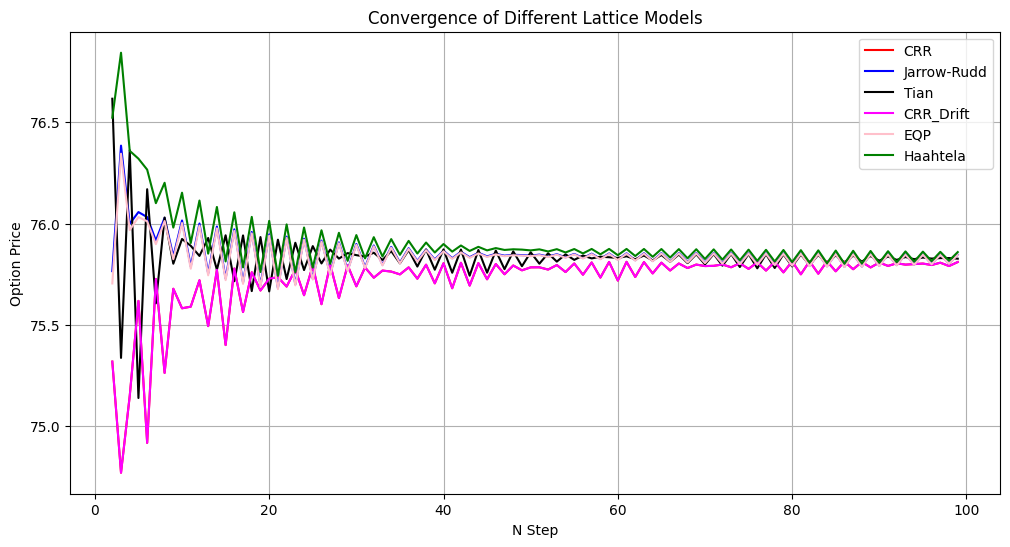

In [36]:
# Function to calculate bond prices using the lattice model
def getPrice_LatticeModel(S0, F, T, r, k, sigma, q, coupon, conversion_ratio, N, model_type, drift=0):
    dt = T / N
    u, d, p = calculate_tree_parameters(r, q, sigma, dt, model_type, drift)

    # Create the binomial stock price tree
    StockPrice = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            StockPrice[j, i] = S0 * (u ** j) * (d ** (i - j))

    # Create the bond price and conversion probability trees
    BondPrice = np.zeros((N + 1, N + 1))
    ConversionProbability = np.zeros((N + 1, N + 1))

    # Calculate bond value at maturity
    for i in range(N + 1):
        BondPrice[i, N] = max(F + coupon, conversion_ratio * StockPrice[i, N])
        ConversionProbability[i, N] = 1 if BondPrice[i, N] == conversion_ratio * StockPrice[i, N] else 0

    # Backward calculation for bond price and conversion probability
    for j in range(N - 1, -1, -1):
        for i in range(j + 1):
            # Calculate the present value of the bond price using risk-neutral probabilities
            BondPrice[i, j] = np.exp(-(r + k) * dt) * (p * BondPrice[i + 1, j + 1] + (1 - p) * BondPrice[i, j + 1])
            ConversionProbability[i, j] = p * ConversionProbability[i + 1, j + 1] + (1 - p) * ConversionProbability[i, j + 1]

    return BondPrice[0, 0]

# Input parameters
S0 = 75           # Initial stock price
F = 100           # Face value of the bond
X = 100           # Strike price for conversion
T = 5             # Time to maturity in years
r = 0.07          # Risk-free rate
k = 0.03          # Credit spread
sigma = 0.2       # Volatility
q = 0             # Dividend yield
coupon = 6        # Annual coupon payment
conversion_ratio = F / X    # Conversion ratio
min_step = 2
max_step = 100    # Number of steps in the tree (reduce for clearer graph)

# Define the list of models to include
model_types = ['CRR', 'Jarrow-Rudd', 'Tian', 'CRR_Drift', 'EQP', 'Haahtela']

# Initialize a dictionary to store the prices for each model
results = {model: np.zeros([max_step - min_step]) for model in model_types}

# Loop through each model and calculate the bond price for varying steps
for model in model_types:
    j = 0
    for i in np.arange(min_step, max_step):
        results[model][j] = getPrice_LatticeModel(S0, F, T, r, k, sigma, q, coupon, conversion_ratio, i, model, drift=0)
        j += 1

# Plotting all models on the same graph
plt.figure(figsize=(12, 6))

# Define a color scheme for each model
colors = {
    'CRR': 'red',
    'Jarrow-Rudd': 'blue',
    'Tian': 'black',
    'CRR_Drift': 'magenta',
    'Haahtela': 'green',
    'EQP': 'pink'
}

# Plot each model with its respective color and label
for model in model_types:
    plt.plot(range(min_step, max_step), results[model], label=model, color=colors[model])

# Add labels and title
plt.xlabel("N Step")
plt.ylabel("Option Price")
plt.title("Convergence of Different Lattice Models")
plt.legend()
plt.grid(True)
plt.show()
